# **Series de tiempo**
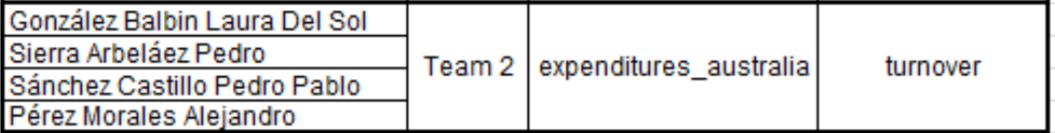

# **1.Entendimiento del problema**
Monthly expenditure on cafes, restaurants and takeaway food services in Victoria
(Australia) from April 1982 up to April 2024.

# **2. Enfoque análitico**
Contruir un modelo de regresión basado en series de tiempo que permita estimar .. con el menor MAE posible 

# **3. Requerimiento de datos**
Se requieren datos pasados del ..

# **4. Recolección de datos**

In [58]:
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
import numpy as np

In [59]:
Data=fetch_dataset(name='expenditures_australia')
Data.index.name = 'turnover' 

expenditures_australia
----------------------
Monthly expenditure on cafes, restaurants and takeaway food services in Victoria
(Australia) from April 1982 up to April 2024.
Australian Bureau of Statistics. Catalogue No. 8501.0
https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-
trade-australia/apr-2024/8501011.xlsx
Shape of the dataset: (505, 1)


In [60]:
Data

,turnover
turnover,
1982-04-01,85.1
1982-05-01,85.1
1982-06-01,82.8
1982-07-01,82.1
1982-08-01,81.8
...,...
2023-12-01,1508.8
2024-01-01,1358.3
2024-02-01,1294.8


In [61]:
inicio_pandemia = '2020-03-01'
fin_pandemia = '2021-10-1'

# Reemplazar los valores del periodo de pandemia con NaN
data = Data.copy()
data.loc[(data.index >= inicio_pandemia) & (data.index <= fin_pandemia)] = np.nan

# **5. Exploración de datos**
- Identíficar los patrones de las serie 
- Determinar la estacionariedad de la serie 

In [62]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from skforecast.plot import set_dark_theme

set_dark_theme()

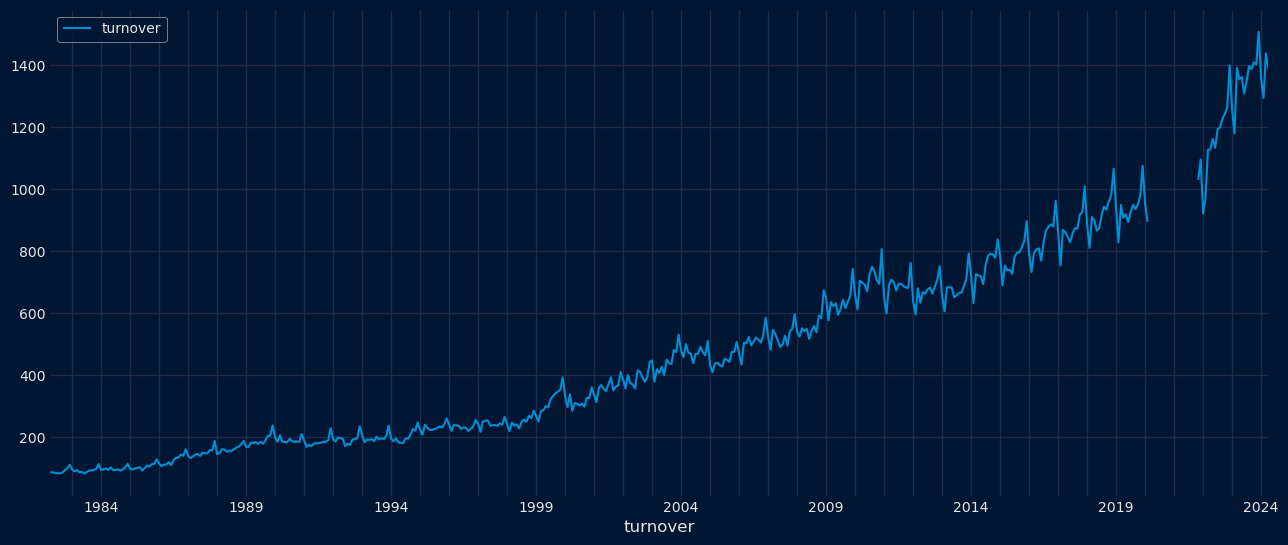

In [63]:
fig, ax = plt.subplots(figsize=(14, 6))
data.plot(ax=ax)
ax.legend()
plt.show()

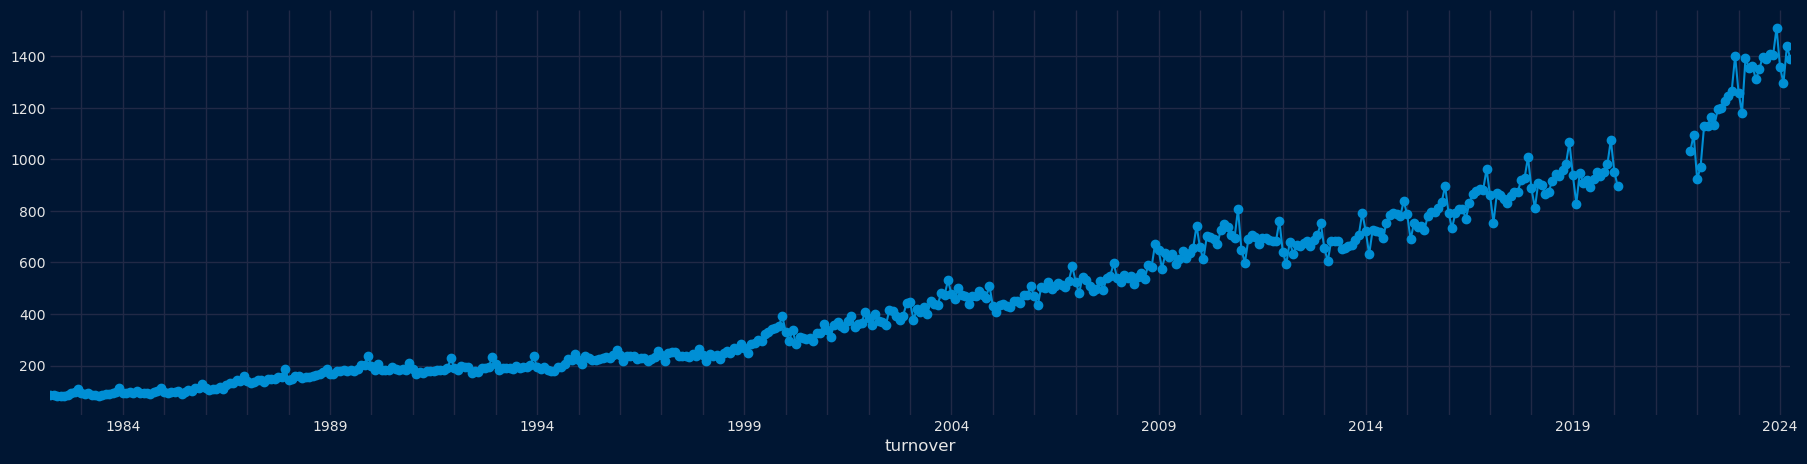

In [64]:
plt.figure(figsize=(20,5))
data['turnover'].plot(marker='o')
plt.show()

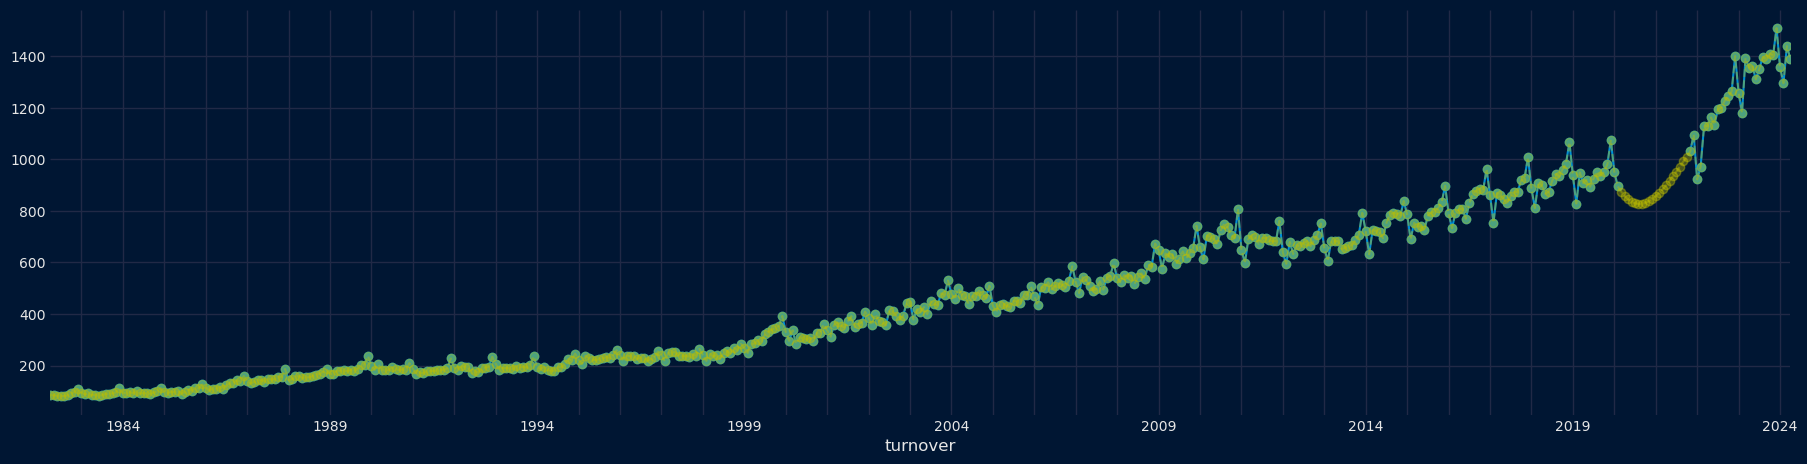

In [65]:
#imputacion por interpolacion de orden superior suavisada, ed de orden cubico , mejor 
plt.figure(figsize=(20,5))
data['turnover'].plot(marker='o')
data=data['turnover'].interpolate(method='akima').plot(color='y',alpha=0.4,ls='dashed', marker= 'o') #aquí cambia 
plt.show()

In [66]:
#imputacion por llenado hacie adelante (series ecnomicas)
plt.figure(figsize=(20,5))
data['turnover'].plot(marker='o')
data['turnover'].ffill().plot(color='y',alpha=0.4,ls='dashed', marker= 'o')
plt.show()

TypeError: 'Axes' object is not subscriptable

<Figure size 2000x500 with 0 Axes>

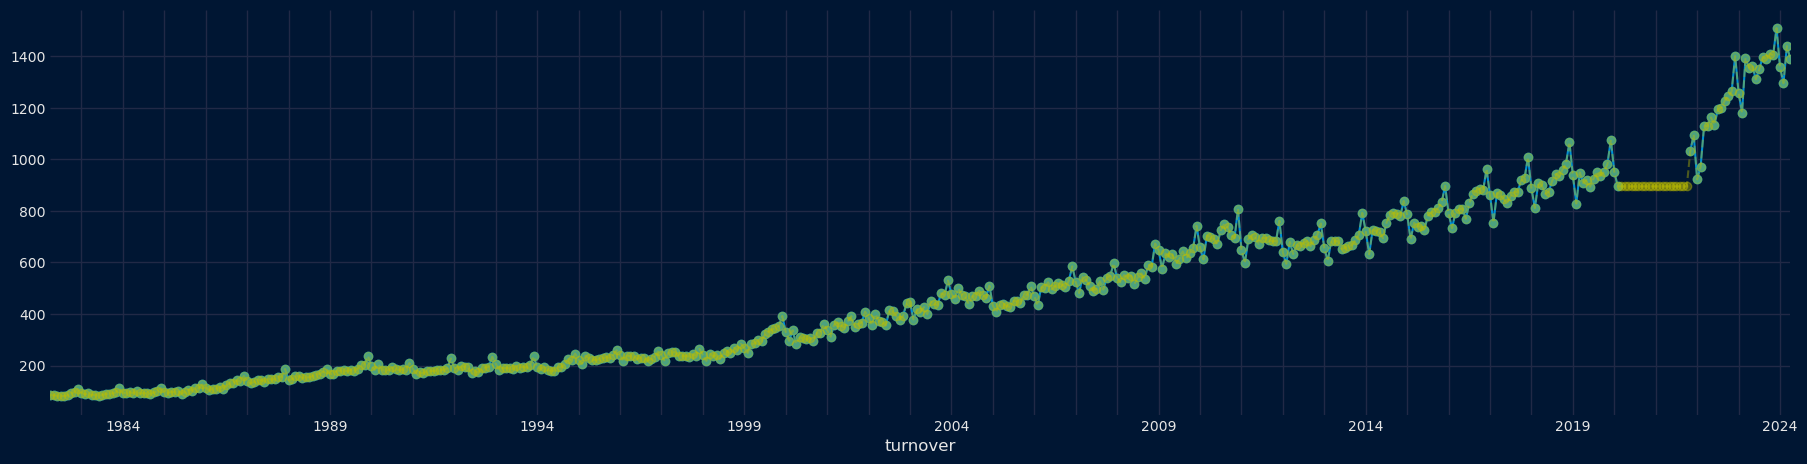

In [ ]:
#imputacion por llenado hacie atrás 
plt.figure(figsize=(20,5))
data['turnover'].plot(marker='o')
data['turnover'].ffill().bfill().plot(color='y',alpha=0.4,ls='dashed', marker= 'o') #aquí cambia 
plt.show()

C:\Users\Laura Gonzalez\AppData\Local\Temp\ipykernel_13944\2765035179.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


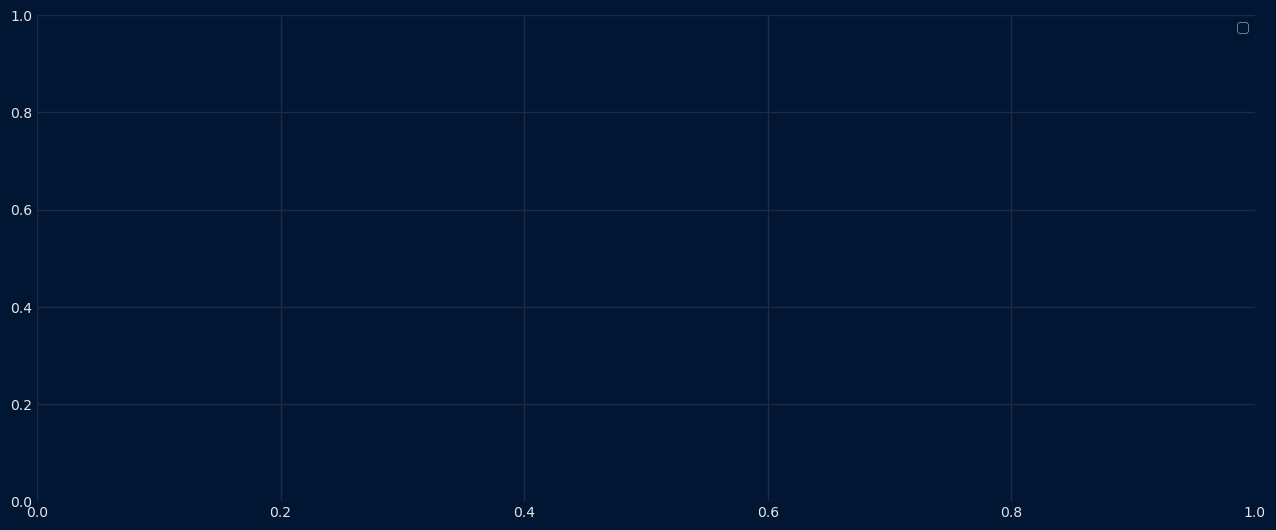

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
data.plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

res_decompose = seasonal_decompose(data['turnover'], model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(4, 1, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=ax[0])
ax[0].set_title('Serie Original')

res_decompose.trend.plot(ax=ax[1])
ax[1].set_title('Tendencia')

res_decompose.seasonal.plot(ax=ax[2])
ax[2].set_title('Estacionalidad')

res_decompose.resid.plot(ax=ax[3])
ax[3].set_title('Residuo')

fig.suptitle('Descomposición de la serie de tiempo', fontsize=16)
plt.show()
# hay una tendencia 

TypeError: 'Axes' object is not subscriptable

In [ ]:
#para confiarmar se hace el test de ickyfuller
def test_estacionaridad(series):
    adfuller_result = adfuller(series)
    print(f'ADF Estadistico: {adfuller_result[0]}')
    print(f'Valor p: {adfuller_result[1]}')
test_estacionaridad(data['turnover'])

ADF Estadistico: 1.1881735702898224
Valor p: 0.9959031465411221


# **6. Preparación de los datos**

preparar lo sdatos teniendo en cuenta que esa preparación va a involucrar una parte de modelamiento 
- Diferenciar la serie 
- identificar su comportamiento estacional

ADF Estadistico: -5.7826299746625205
Valor p: 5.084063177247697e-07


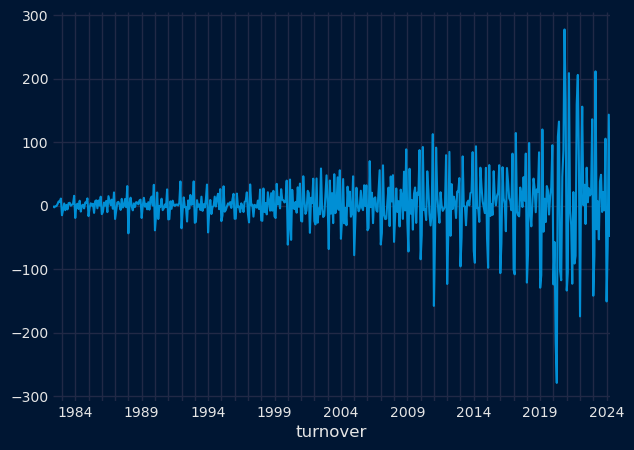

In [ ]:
data_diff = data['turnover'].diff().dropna()
test_estacionaridad(data_diff)
data_diff.plot()
plt.show()
#Aquí la graficamos de una vez, una serie diferenciada que cumple con las dos condiciones de estacionariedad
#mientras mas negativo el pval tira más a la banda izq
#efecto nocivo en diferenciar mucho una serie y es que voy perdiendo diferenciacion
#si se puede hacer en un modelo sarimax
#lo que se hace en dif es que toma el valor de t1 y lo resta en t0 

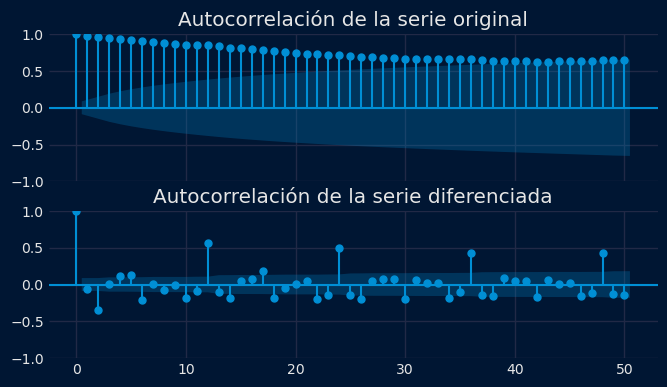

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Grafico de autocorrelacion
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)

plot_acf(data['turnover'], ax=ax[0], lags=50, alpha=0.05)
ax[0].set_title('Autocorrelación de la serie original')

plot_acf(data_diff, ax=ax[1], lags=50, alpha=0.05)
ax[1].set_title('Autocorrelación de la serie diferenciada')

plt.show()
#la diferenciacion aritmetica lo uqe hace es quitar el factor incremental constante en el tiempo de la tendencia 
#cuando se mira la autocorr empezamos a mirar 2 elementos, que tanto es la corr del valor hoy con respecto al valor arnterior, generando una barras de aprovacion o de rechazo. Ibamos a contar la cantidad de resagos de la media movil
#sobre la serie dif se diseña
#cuantos resagos etan por fuera d el abanda de rechazo? 0, el primero no se cuenta. 
#la serie tiene un componente estacional cada 12 periodos. 
#por tanto debemos identificasr P D Q ya que son  las que me hablan del componente estacional. si en nuestros trabajos llegamos a tener esos valore entonces debemos hacer esto 
#se debe eliminar esa tendencia a la componente estacional 

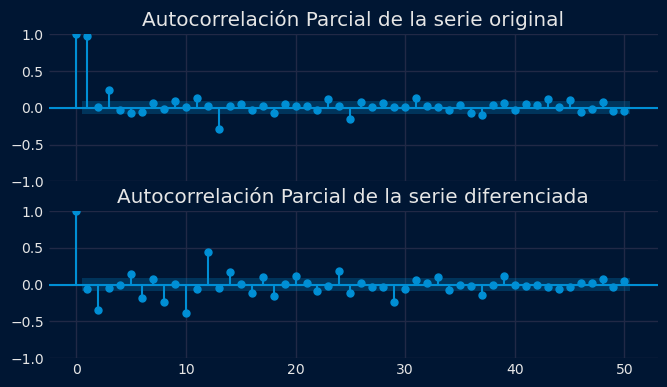

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Grafico de autocorrelacion
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)

plot_pacf(data['turnover'], ax=ax[0], lags=50, alpha=0.05)
ax[0].set_title('Autocorrelación Parcial de la serie original')

plot_pacf(data_diff, ax=ax[1], lags=50, alpha=0.05)
ax[1].set_title('Autocorrelación Parcial de la serie diferenciada')

plt.show()
# para p nos vamos con la auto corr
#cuantos resagos etan por fuera d el abanda de rechazo? sigue siendo 0 . el eje x son resagos o valores en el tiempo y y es la corr que va entre -1 y 1.


In [ ]:
#diferenciacion de la serie estacional
#primer diff resta uno a uno, periodo a periodo, segundo diff resta cada 12 periodos para quitar componente estacional
data_diff_12= data['turnover'].diff().diff(12).dropna()
adfuller_result=adfuller(data_diff_12)
print(f'ADF Statistics:{adfuller_result[0]}, p-value:{adfuller_result[1]}')

ADF Statistics:-5.616525344582816, p-value:1.1709780822603426e-06


<Figure size 700x300 with 0 Axes>

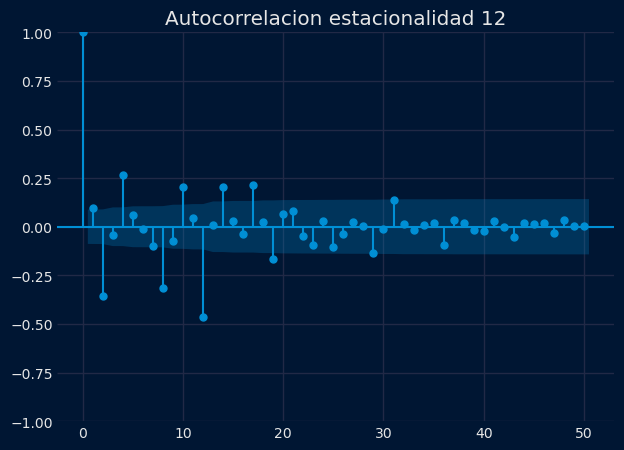

In [ ]:
#aqui vamos a utilizar la que acabamos de diff
#gráfico de autocorrelacion de la serie estacionaria estacional
plt.figure(figsize=(7,3))
plot_acf(data_diff_12, lags=50,alpha=0.05)
plt.title('Autocorrelacion estacionalidad 12')
plt.show()
#cuánto es Q? es 1, pues solo un resago sale de las bandas
#Cuanto es P? 2

## **Nuestro SARIMAX es**


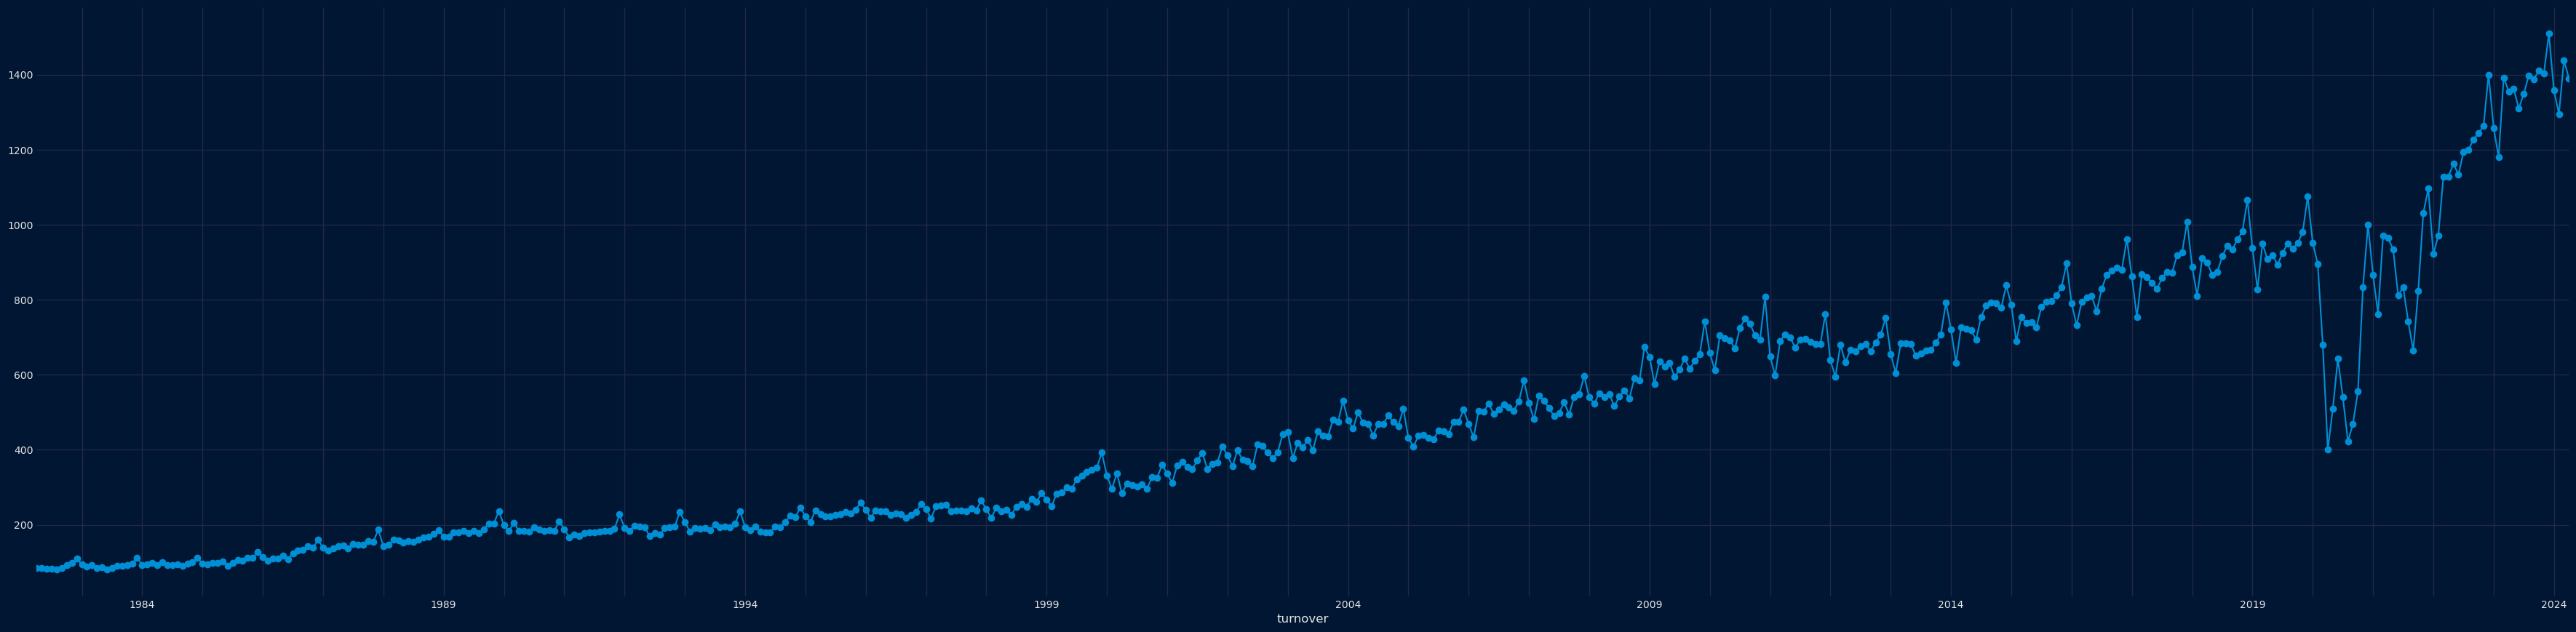

In [ ]:
#imputación 
plt.figure(figsize=(40,10))
data['turnover'].plot(marker='o')
plt.show()
#según veo no hay datos nulos, entonces no hay que hacer imputación 

### **Separar entre entrenamiento y prueba** 
- este no puede ser aleatorio , ya que el valor futuro depende de los valores pasados. 
- los valores más antiguos van a ser el 70% (train) y el 30% más nuevos (test).
- En la pandemia todo fue muy raro , se elimina la pandemia y se puede tratar como nulos e imoutar 

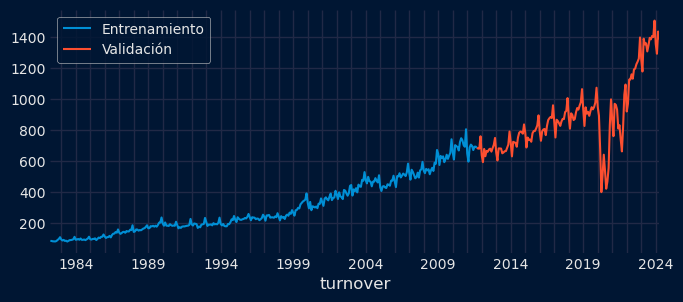

In [ ]:
#entrenamiento y prueba 
#El 70% del intervalo entre el 1 de abril de 1982 y el 1 de abril de 2024 corresponde aproximadamente al 1 de septiembre de 2011.
#2011-09-01
end_train= '2011-09-01'
data_train= data['turnover'].loc[:end_train]
data_test=data['turnover'].loc[end_train:]
plt.figure(figsize=(7,3))
data_train.plot(label='Entrenamiento')
data_test.plot(label='Validación')
plt.legend()
plt.show()


## **7. Modelado**
- Sarimax
- Forecater
- RNA secuencial

In [ ]:
#Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo_sarimax= SARIMAX(data_train, order=(,,), seasonal_order=(,,,))
modelo_sarimax= modelo_sarimax.fit(disp=0)# dsip no muestra iter
modelo_sarimax.summary()

SyntaxError: invalid syntax (1507092593.py, line 3)

In [ ]:
pred_sarimax=modelo_sarimax.get_forecast(steps=len(data_test)).predicted_mean
pred_sarimax.name='predicciones_sarimax'
display(pred_sarimax.head(4))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data_train,label= 'Entrenamiento')
plt.plot(data_test, label='Validación')
plt.plot(pred_sarimax, label='Pronosticos')
plt.legend()
plt.show()
#el modelo predijo bien lo que se necesita 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape_sarimax=mean_absolute_percentage_error(data_test, pred_sarimax)
mape_sarimax
#primer modelo y el mas complicado 

In [ ]:
#forecaster 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import plot_prediction_intervals

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data_train,label= 'Entrenamiento')
plt.plot(data_test, label='Validación')

plt.legend()
plt.show()

In [ ]:
forecaster_1 = ForecasterRecursive(regressor= LinearRegression() ,
                                    lags = 15, window_features= RollingFeatures(stats=['mean'], window_sizes=10))  # utilizamos la ventana donde se crea una ventanita fija y esos lags para poder predecir los siguientes y suavisar . lo que le decimos es que coja el primero de los primeros 10 y que algo del modelo 
forecaster_1.fit(y=data_train, store_in_sample_residuals=True)
forecaster_1
#lags es 5 

In [ ]:
#presicciones con ese forecaster
predictions_1= forecaster_1.predict(steps=len(data_test))
predictions_1

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data_train,label= 'Entrenamiento')
plt.plot(data_test, label='Validación')
plt.plot(predictions_1,label='predicción es reg lineal')
plt.legend()
plt.show()

In [ ]:
mean_absolute_percentage_error(data_test, predictions_1)

In [ ]:
# al hacer estas predicciones es bueno graficar lo sintervalos de prediccion . El -1 es porque la predicion da hasta 1 m es mas 
predictions_1_interval = forecaster_1.predict_interval(steps=len(data_test)- 1,
                                                       interval=[5,95],
                                                       method='bootstrapping', n_boot=100)
plot_prediction_intervals(predictions=predictions_1_interval, y_true=data_test, target_variable='y',
                          kwargs_fill_between={'color':'yellow','alpha':0.3})

plt.show()

In [ ]:
forecaster_1 = ForecasterRecursive(regressor= DecisionTreeRegressor(random_state=42) ,
                                    lags = 15, window_features= RollingFeatures(stats=['mean'], window_sizes=10))  # utilizamos la ventana donde se crea una ventanita fija y esos lags para poder predecir los siguientes y suavisar . lo que le decimos es que coja el primero de los primeros 10 y que algo del modelo 
forecaster_1.fit(y=data_train, store_in_sample_residuals=True)
forecaster_1
#lags es 5 

In [ ]:
predictions_2= forecaster_1.predict(steps=len(data_test))
predictions_2